In [1]:
from IPython.display import HTML

def new_section(title):
    style = "text-align:center;background:#40A8D9;padding:25px;color:#ffffff;font-size:3em;"
    return HTML('<div style="{}">{}</div>'.format(style, title))
def new_title(title):
    style = "text-align:center;background:#40A8D9;padding:25px;color:#ffffff;font-size:4em;"
    return HTML('<div style="{}">{}</div>'.format(style, title))

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
new_title("Credit Card Fraud Alert")

In [85]:
# load libraries
import pandas as pd
import numpy as np

# load plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="bright", color_codes=True)
palette=sns.color_palette()

# load ML libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

# stats tools
from scipy.stats import randint as sp_randint
from scipy.stats import norm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# read csv file
df = pd.read_csv('./creditcard.csv')

In [5]:
# Inspect dataframe
df.shape

(284807, 31)

In [6]:
# Inspect data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# Inspect data
df[['Amount','Class']].describe()

,Amount,Class
count,284807.000000,284807.000000
mean,88.349619,0.001727
std,250.120109,0.041527
min,0.000000,0.000000
25%,5.600000,0.000000
50%,22.000000,0.000000
75%,77.165000,0.000000
max,25691.160000,1.000000


In [8]:
# Find null records
df.isnull().sum().sum()

0

In [9]:
# Class distribution
print('Fraudulent transactions: ', round(df['Class'].value_counts()[1]/df.shape[0]*100,2),'%')
print('Regular transactions: ', round(df['Class'].value_counts()[0]/df.shape[0]*100,2),'%')

Fraudulent transactions:  0.17 %
Regular transactions:  99.83 %


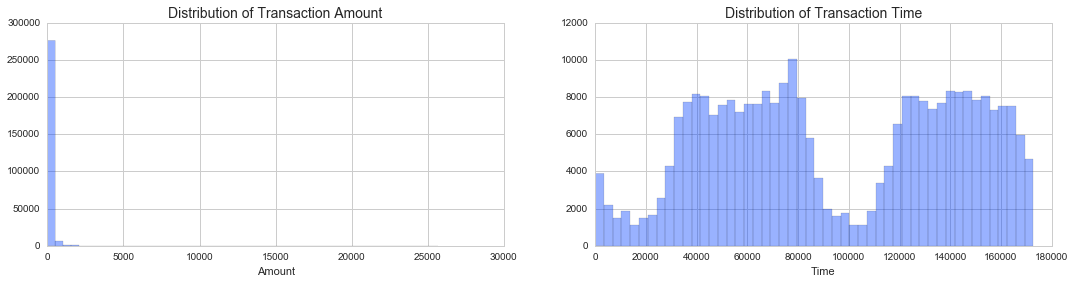

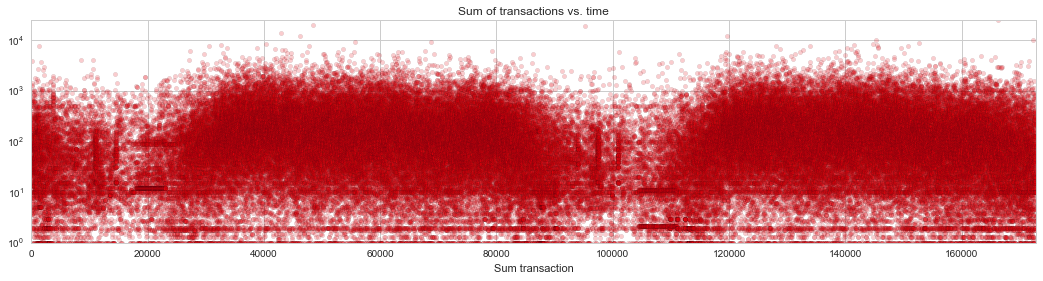

In [10]:
# Data inspection
amount_ser = df['Amount']
time_ser = df['Time']
group = df[['Amount','Time']].groupby('Time').sum()

fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.distplot(amount_ser,kde=None,ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
sns.distplot(time_ser,kde=None,ax=ax[1])
ax[1].set_title('Distribution of Transaction Time', fontsize=14)

fig, ax = plt.subplots(1, 1, figsize=(18,4))
plt.scatter(group.index,group['Amount'],alpha=0.2,c='r')
ax.set_title('Sum of transactions vs. time')
ax.set_xlabel('Time')
ax.set_xlabel('Sum transaction')
ax.set_yscale('log')
ax.set_ylim(1,amount_ser.max())
ax.set_xlim(0,time_ser.max());

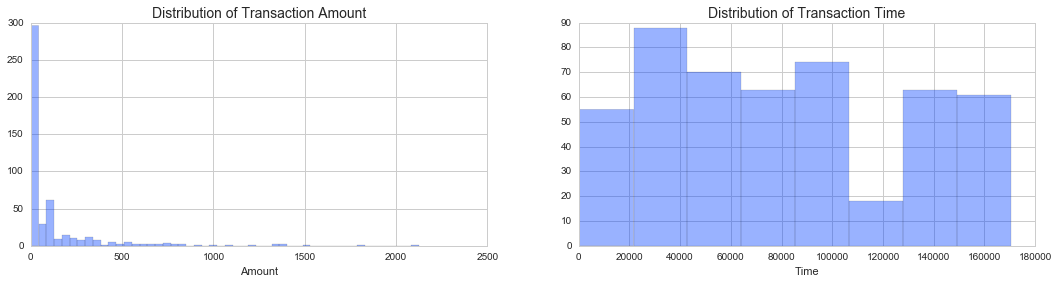

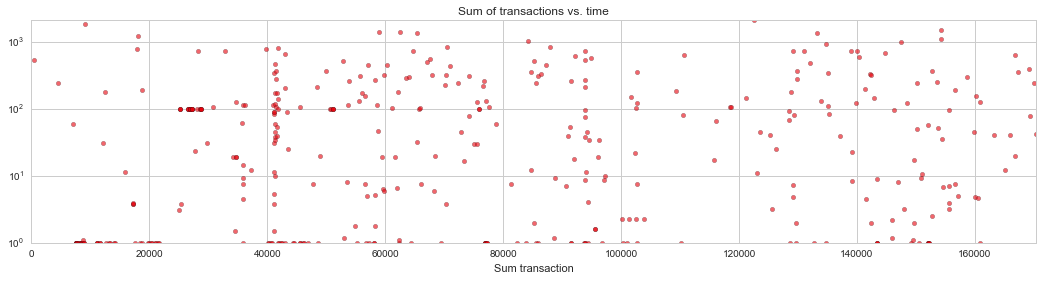

In [11]:
# Inspect fraudulent transactions
amount_ser = df[df['Class']==1]['Amount']
time_ser = df[df['Class']==1]['Time']
group = df[df['Class']==1][['Amount','Time']].groupby('Time').sum()

fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.distplot(amount_ser,kde=None,ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
sns.distplot(time_ser,kde=None,ax=ax[1])
ax[1].set_title('Distribution of Transaction Time', fontsize=14)

fig, ax = plt.subplots(1, 1, figsize=(18,4))
plt.scatter(group.index,group['Amount'],alpha=0.6,c='r')
ax.set_title('Sum of transactions vs. time')
ax.set_xlabel('Time')
ax.set_xlabel('Sum transaction')
ax.set_yscale('log')
ax.set_ylim(1,amount_ser.max())
ax.set_xlim(0,time_ser.max());

In [12]:
# scale the data for the time and amount features
std_scaler = StandardScaler()
rbd_scaler = RobustScaler()

df['scaled_amount'] = rbd_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rbd_scaler.fit_transform(df['Time'].values.reshape(-1,1))

del df['Time']
del df['Amount']

df[['scaled_amount','scaled_time']].describe()

,scaled_amount,scaled_time
count,284807.000000,284807.000000
mean,0.927124,0.118914
std,3.495006,0.557903
min,-0.307413,-0.994983
25%,-0.229162,-0.358210
50%,0.000000,0.000000
75%,0.770838,0.641790
max,358.683155,1.035022


In [13]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [14]:
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=10)

In [15]:
# shuffle the data
df = df.sample(frac=1)

# isolate classes
df_fraud = df.loc[df['Class']==1]
df_non_fraud = df.loc[df['Class']==0][0:df_fraud.shape[0]]

# concatenate the balanced samples
df_balanced = pd.concat([df_fraud, df_non_fraud])

# shuffle the balanced df
df_balanced = df_balanced.sample(frac=1,random_state=10)
df_balanced.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
95597,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,-1.016592,-4.320536,...,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1,18.615944,-0.226824
52584,-1.519244,2.308492,-1.503599,2.064101,-1.000845,-1.016897,-2.059731,-0.275166,-1.562206,-2.755797,...,0.102826,-0.017746,0.149696,-0.096602,-0.369115,-0.019244,-0.208319,1,-0.293440,-0.459956
239600,-1.043476,0.324663,0.392015,-0.524252,0.979782,0.189047,0.631925,-1.092896,0.645295,-0.270524,...,-0.616909,-0.157946,0.028307,0.065110,0.039623,-0.224803,-0.022595,0,0.530986,0.769346
10801,-14.474437,6.503185,-17.712632,11.270352,-4.150142,-3.372098,-16.535807,-1.443947,-6.815273,-13.670545,...,0.342391,-3.564508,-0.818140,0.153408,0.755079,2.706566,-0.992916,1,-0.293440,-0.778827
42528,-4.595617,5.083690,-7.581015,7.546033,-6.949165,-1.729185,-8.190192,2.714670,-7.083169,-11.141278,...,0.566844,0.033744,0.591783,0.334229,0.386801,2.163898,0.983104,1,4.445050,-0.511684


Class distribution in balanced dataframe:
1    0.5
0    0.5
Name: Class, dtype: float64


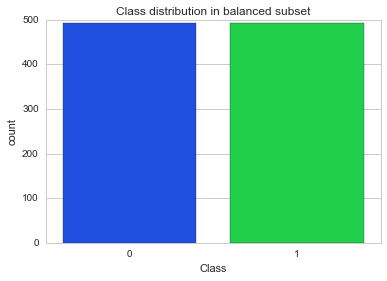

In [16]:
# inspect the balanced df
print("Class distribution in balanced dataframe:")
print(df_balanced['Class'].value_counts()/df_balanced.shape[0])

# plot the data
sns.countplot(data=df_balanced,x='Class')
plt.title("Class distribution in balanced subset");

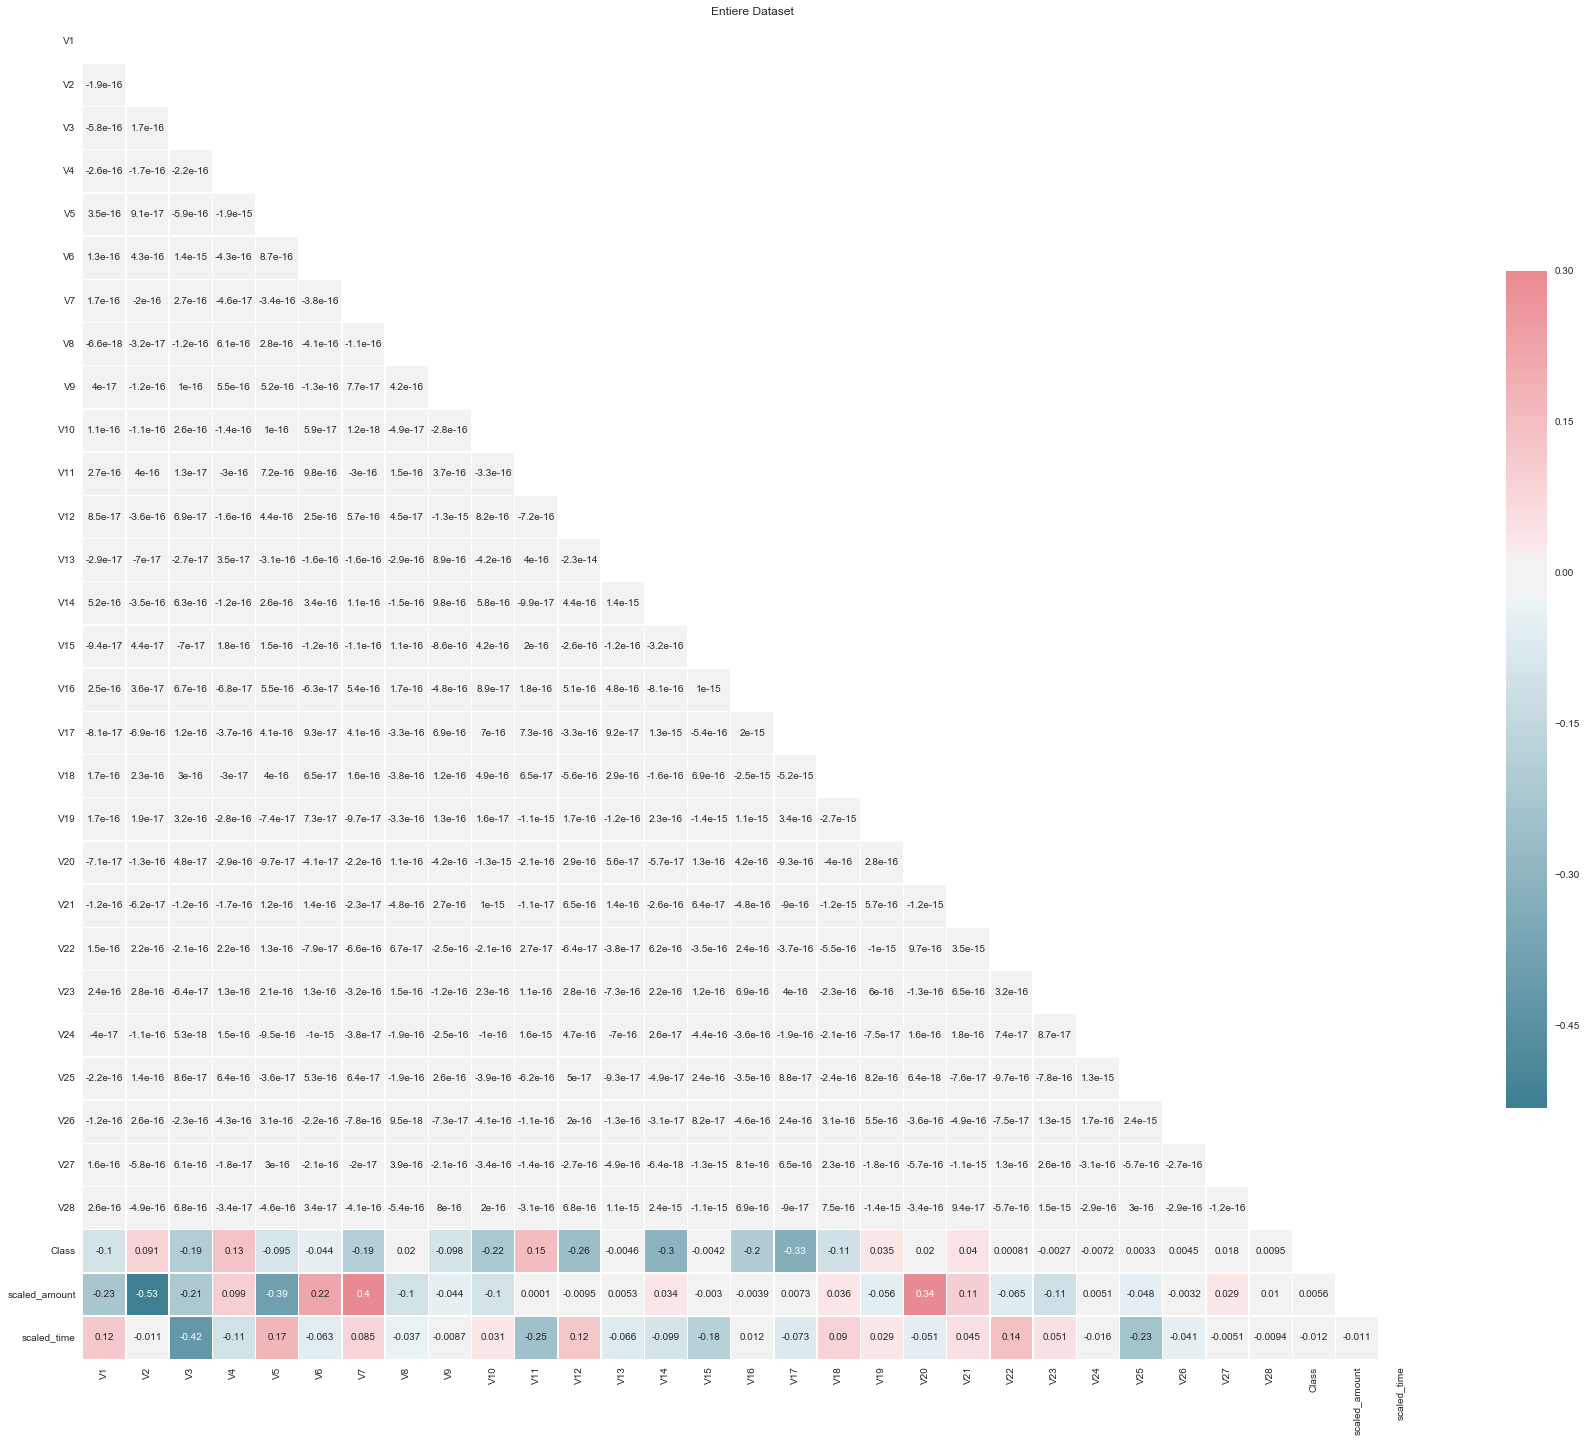

In [17]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(1,figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5},ax=ax,annot=True)
plt.title('Entiere Dataset');

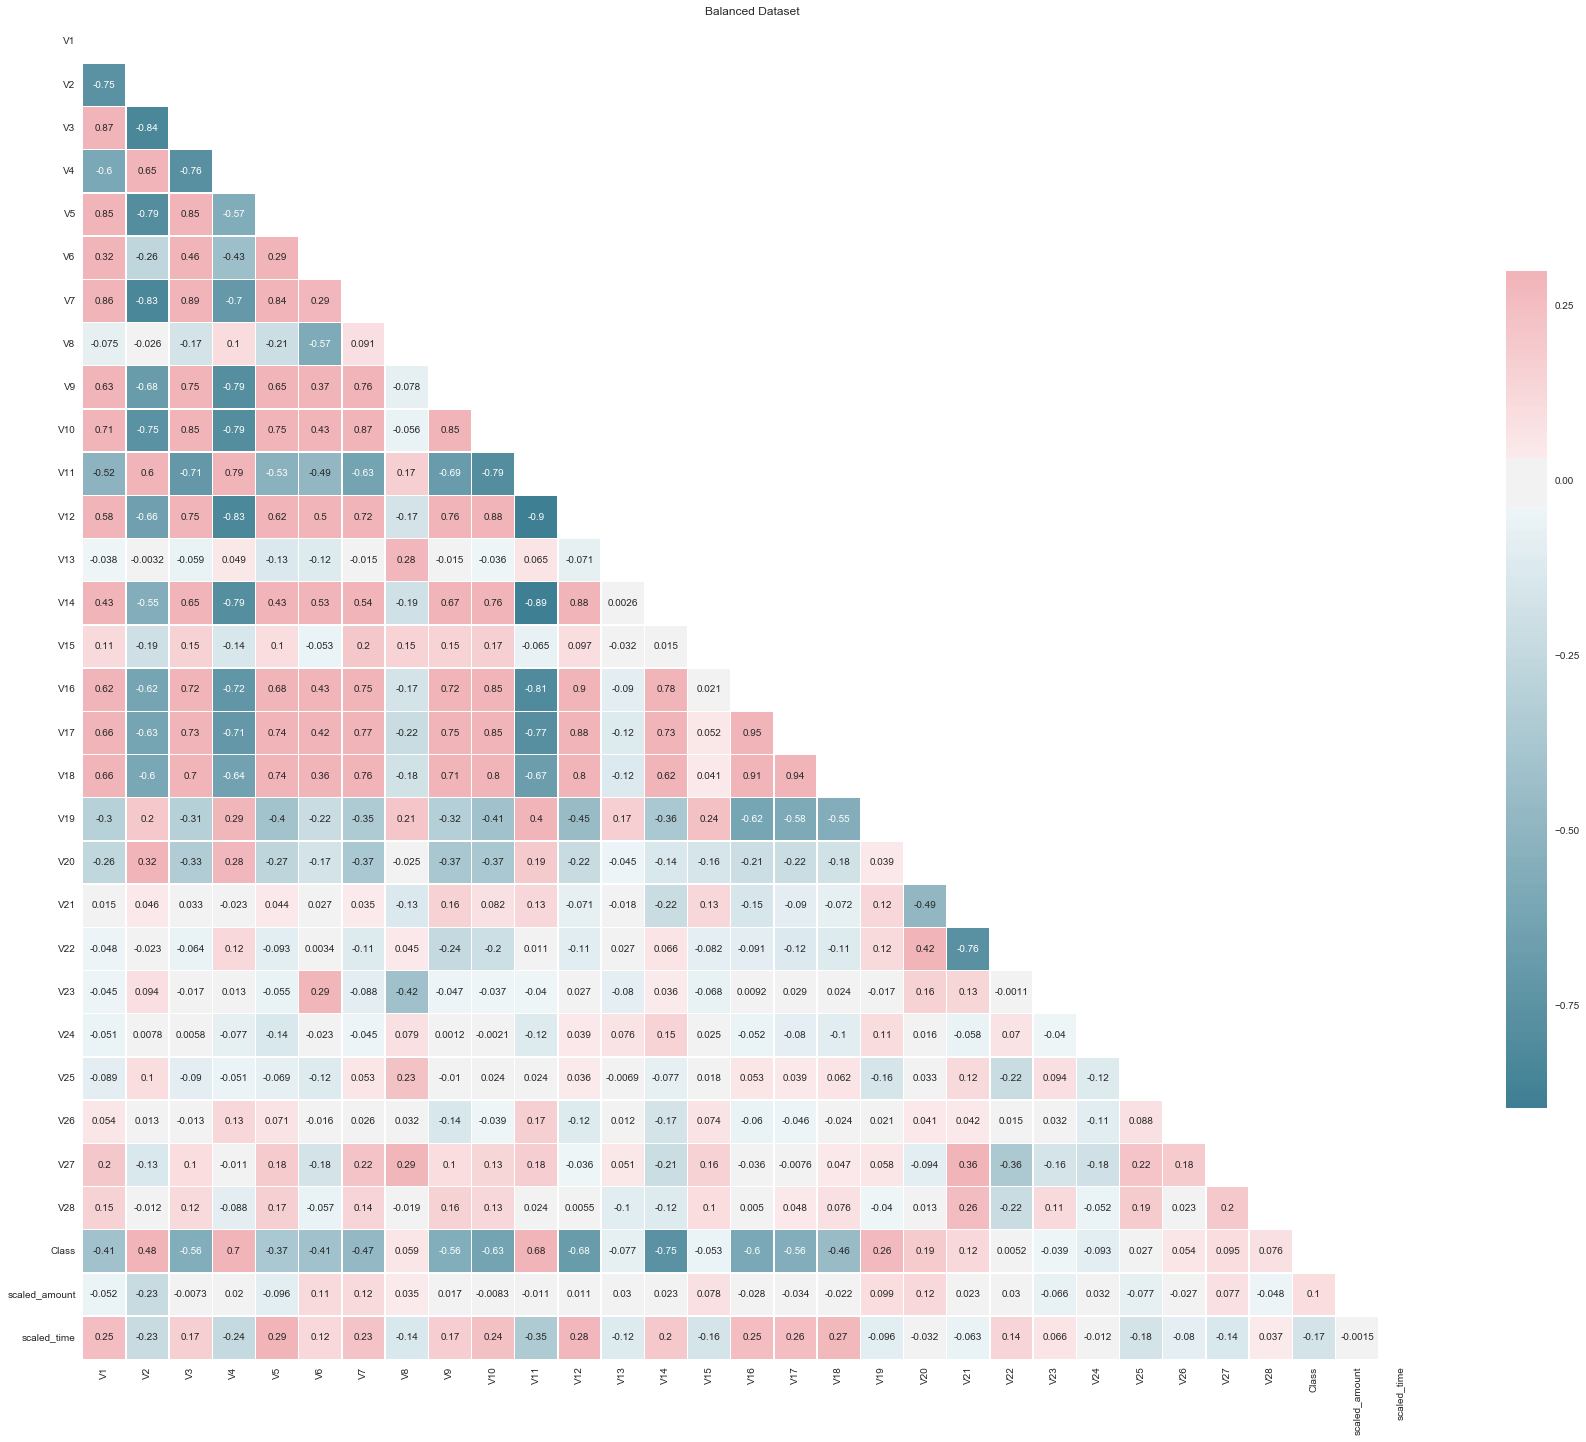

In [18]:
# Compute the correlation matrix
corr = df_balanced.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(1,figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5},ax=ax,annot=True)
plt.title('Balanced Dataset');

In [19]:
df_balanced.corr()['Class'].sort_values(ascending=False)[1:5]

V4     0.700397
V11    0.684050
V2     0.478711
V19    0.262661
Name: Class, dtype: float64

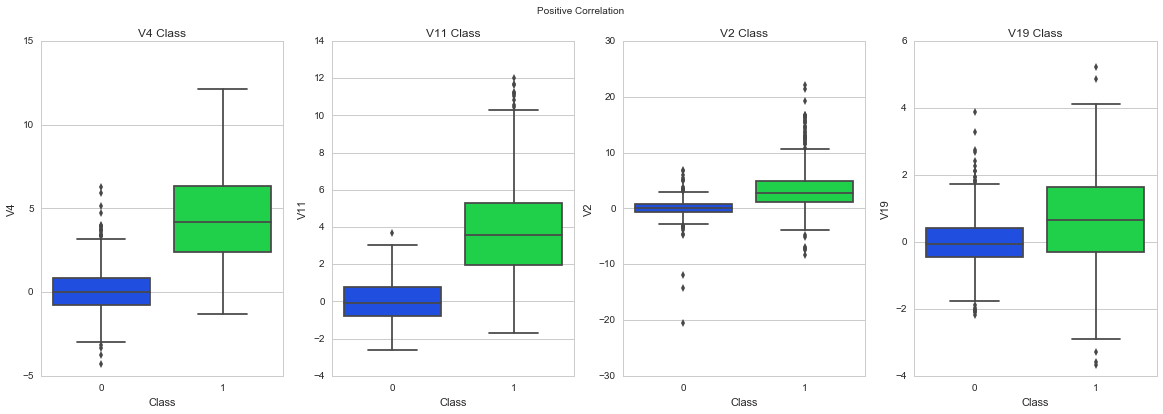

In [20]:
# Investigate positive correlation
fig, ax = plt.subplots(1,4,figsize=(20,6))
fig.suptitle("Positive Correlation")
sns.boxplot(x='Class',y='V4',data=df_balanced,ax=ax[0])
ax[0].set_title('V4 Class')

sns.boxplot(x='Class',y='V11',data=df_balanced,ax=ax[1])
ax[1].set_title('V11 Class')

sns.boxplot(x='Class',y='V2',data=df_balanced,ax=ax[2])
ax[2].set_title('V2 Class')

sns.boxplot(x='Class',y='V19',data=df_balanced,ax=ax[3])
ax[3].set_title('V19 Class');

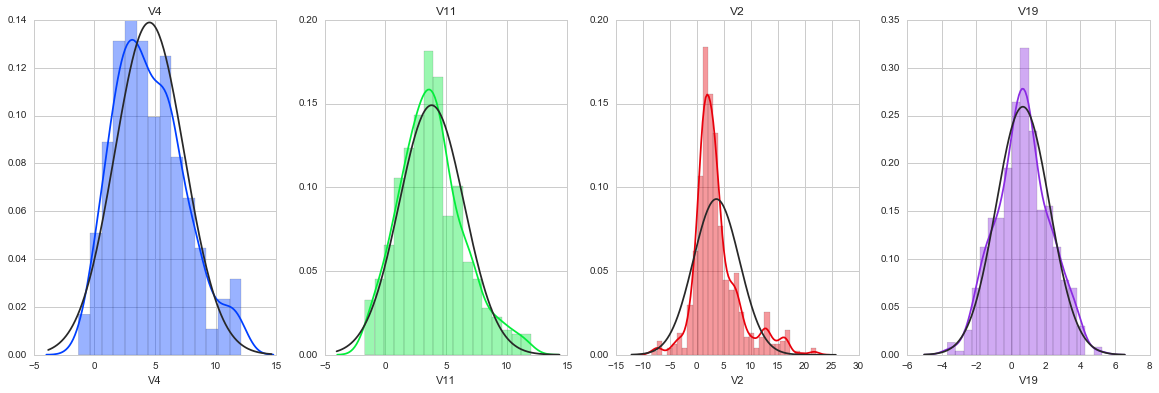

In [21]:
fig, ax = fig, ax = plt.subplots(1,4,figsize=(20,6))
sns.distplot(df_balanced[df_balanced['Class']==1]['V4'],ax=ax[0],fit=norm,color=palette[0])
ax[0].set_title('V4')
sns.distplot(df_balanced[df_balanced['Class']==1]['V11'],ax=ax[1],fit=norm,color=palette[1])
ax[1].set_title('V11')
sns.distplot(df_balanced[df_balanced['Class']==1]['V2'],ax=ax[2],fit=norm,color=palette[2])
ax[2].set_title('V2')
sns.distplot(df_balanced[df_balanced['Class']==1]['V19'],ax=ax[3],fit=norm,color=palette[3])
ax[3].set_title('V19');

In [22]:
df_balanced.corr()['Class'].sort_values(ascending=True)[0:4]

V14   -0.751434
V12   -0.681031
V10   -0.631308
V16   -0.599479
Name: Class, dtype: float64

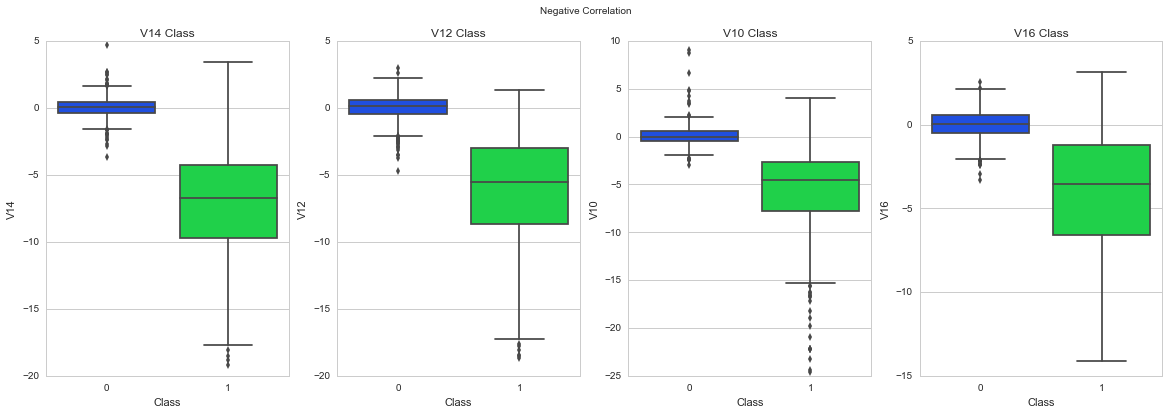

In [23]:
fig, ax = plt.subplots(1,4,figsize=(20,6))
fig.suptitle("Negative Correlation")
sns.boxplot(x='Class',y='V14',data=df_balanced,ax=ax[0])
ax[0].set_title('V14 Class')

sns.boxplot(x='Class',y='V12',data=df_balanced,ax=ax[1])
ax[1].set_title('V12 Class')

sns.boxplot(x='Class',y='V10',data=df_balanced,ax=ax[2])
ax[2].set_title('V10 Class')

sns.boxplot(x='Class',y='V16',data=df_balanced,ax=ax[3])
ax[3].set_title('V16 Class');

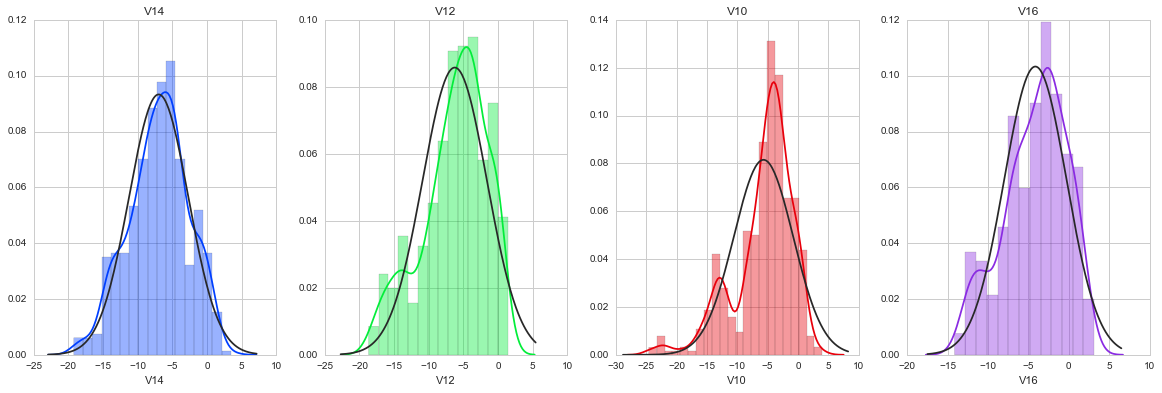

In [24]:
fig, ax = fig, ax = plt.subplots(1,4,figsize=(20,6))
sns.distplot(df_balanced[df_balanced['Class']==1]['V14'],ax=ax[0],fit=norm,color=palette[0])
ax[0].set_title('V14')
sns.distplot(df_balanced[df_balanced['Class']==1]['V12'],ax=ax[1],fit=norm,color=palette[1])
ax[1].set_title('V12')
sns.distplot(df_balanced[df_balanced['Class']==1]['V10'],ax=ax[2],fit=norm,color=palette[2])
ax[2].set_title('V10')
sns.distplot(df_balanced[df_balanced['Class']==1]['V16'],ax=ax[3],fit=norm,color=palette[3])
ax[3].set_title('V16');

In [25]:
# Remove outliers using IQR

# Class V14
v14_fraud = df_balanced['V14'].loc[df_balanced['Class']==1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25
print("V14 IQR=", v14_iqr)
v14_cutoff = 1.5*(v14_iqr)
v14_lower, v14_upper = q25-v14_cutoff, q75+v14_cutoff
mask = df_balanced[(df_balanced['V14']<v14_lower) | (df_balanced['V14']>v14_upper)].index
df_balanced = df_balanced.drop(mask)
print('Dropped by V14=', len(mask))


# Class V12
v12_fraud = df_balanced['V12'].loc[df_balanced['Class']==1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
print("V12 IQR=", v12_iqr)
v12_cutoff = 1.5*(v12_iqr)
v12_lower, v12_upper = q25-v12_cutoff, q75+v12_cutoff
mask=df_balanced[(df_balanced['V12']<v12_lower) | (df_balanced['V12']>v12_upper)].index
df_balanced = df_balanced.drop(mask)
print('Dropped by V12=', len(mask))

# Class V10
v10_fraud = df_balanced['V10'].loc[df_balanced['Class']==1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
print("V10 IQR=", v10_iqr)
v10_cutoff = 1.5*(v10_iqr)
v10_lower, v10_upper = q25-v10_cutoff, q75+v10_cutoff
mask=df_balanced[(df_balanced['V10']<v10_lower) | (df_balanced['V10']>v10_upper)].index
df_balanced = df_balanced.drop(mask)
print('Dropped by V10=', len(mask))
print()

print(df_balanced['Class'].shape[0])

V14 IQR= 5.409902115485519
Dropped by V14= 5
V12 IQR= 5.780002635714835
Dropped by V12= 4
V10 IQR= 4.954797397665596
Dropped by V10= 30

945


In [26]:
X = df_balanced.drop('Class', axis=1)
y = df_balanced['Class']

X_balanced_TSNE = TSNE(n_components=2, random_state=10).fit_transform(X.values)
X_balanced_PCA = PCA(n_components=2, random_state=10).fit_transform(X.values)
X_balanced_SVD = TruncatedSVD(n_components=2, algorithm='randomized', random_state=10).fit_transform(X.values)

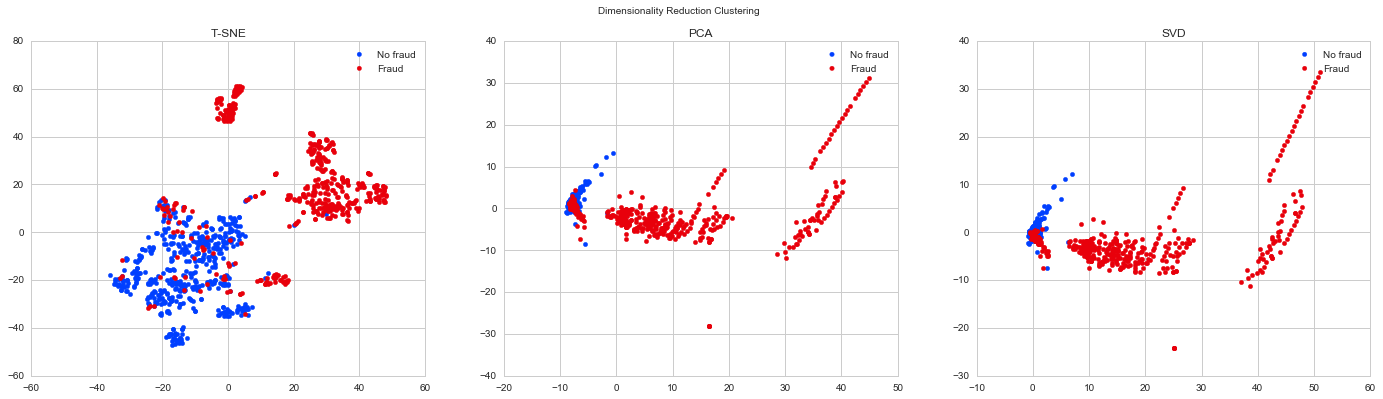

In [27]:
# plot dimensionality reductions
fig, ax = plt.subplots(1,3,figsize=(24,6))
fig.suptitle('Dimensionality Reduction Clustering')

# T-SNE
ax[0].scatter(X_balanced_TSNE[y==0,0],X_balanced_TSNE[y==0,1],color=palette[0],label='No fraud')
ax[0].scatter(X_balanced_TSNE[y==1,0],X_balanced_TSNE[y==1,1],color=palette[2],label='Fraud')
ax[0].legend(loc='best')
ax[0].set_title('T-SNE')
# PCA
ax[1].scatter(X_balanced_PCA[y==0,0],X_balanced_PCA[y==0,1],color=palette[0],label='No fraud')
ax[1].scatter(X_balanced_PCA[y==1,0],X_balanced_PCA[y==1,1],color=palette[2],label='Fraud')
ax[1].legend(loc='best')
ax[1].set_title('PCA')
# SVD
ax[2].scatter(X_balanced_SVD[y==0,0],X_balanced_SVD[y==0,1],color=palette[0],label='No fraud')
ax[2].scatter(X_balanced_SVD[y==1,0],X_balanced_SVD[y==1,1],color=palette[2],label='Fraud')
ax[2].legend(loc='best')
ax[2].set_title('SVD');

In [29]:
X = df_balanced.drop('Class', axis=1)
y = df_balanced['Class']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

In [34]:
# models
models = {"Logistic Regression":LogisticRegression(),
         "K-nearest neighbors":KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Decision Tree": DecisionTreeClassifier(),
         "Support Vector Classifier": SVC()}

In [40]:
for key, model in models.items():
    model.fit(X_train,y_train)
    train_score = cross_val_score(model, X_train, y_train, cv=5)
    print("Model:", model.__class__.__name__,"- Accuracy =",round(train_score.mean()*100,2),"%.")

Model: LogisticRegression - Accuracy = 95.37 %.
Model: KNeighborsClassifier - Accuracy = 93.78 %.
Model: RandomForestClassifier - Accuracy = 94.31 %.
Model: DecisionTreeClassifier - Accuracy = 90.88 %.
Model: SVC - Accuracy = 92.86 %.


In [57]:
best_params = {}

# hyper parameter tuning
# Logisting Regression
params = {'penalty':['l1','l2'], 'C':10**np.linspace(-5,1,20)}
grid_cs_log_reg = GridSearchCV(LogisticRegression(),params)
grid_cs_log_reg.fit(X_train,y_train)
best_params['Logistic Regression'] = grid_cs_log_reg.best_estimator_

# KNN classifier
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10],'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_cs_knn = GridSearchCV(KNeighborsClassifier(),params)
grid_cs_knn.fit(X_train,y_train)
best_params['K-nearest neighbors'] = grid_cs_knn.best_estimator_
    
# Random Forest
params = {"max_depth": [3, None],
              "max_features": np.random.randint(1, 11,4),
              "min_samples_split": np.random.randint(2, 11,4),
              "min_samples_leaf": np.random.randint(1, 11,4),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
grid_cs_rdf = GridSearchCV(RandomForestClassifier(),params)
grid_cs_rdf.fit(X_train,y_train)
best_params['Random Forest'] = grid_cs_rdf.best_estimator_

# Decision Tree
params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,10,1)), 
              "min_samples_leaf": list(range(5,10,1))}
grid_cs_dtree = GridSearchCV(DecisionTreeClassifier(),params)
grid_cs_dtree.fit(X_train,y_train)
best_params['Decision Tree'] = grid_cs_dtree.best_estimator_

# SVC
params = {'C':10**np.linspace(-5,1,20), 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_cs_svc = GridSearchCV(SVC(),params)
grid_cs_svc.fit(X_train,y_train)
best_params['Support Vector Classifier'] = grid_cs_svc.best_estimator_

In [64]:
print("Model:", grid_cs_log_reg.estimator.__class__.__name__,"- Accuracy =",round(grid_cs_log_reg.best_score_*100,2),"%.")
print("Model:", grid_cs_knn.estimator.__class__.__name__,"- Accuracy =",round(grid_cs_knn.best_score_*100,2),"%.")
print("Model:", grid_cs_rdf.estimator.__class__.__name__,"- Accuracy =",round(grid_cs_rdf.best_score_*100,2),"%.")
print("Model:", grid_cs_dtree.estimator.__class__.__name__,"- Accuracy =",round(grid_cs_dtree.best_score_*100,2),"%.")
print("Model:", grid_cs_svc.estimator.__class__.__name__,"- Accuracy =",round(grid_cs_svc.best_score_*100,2),"%.")

Model: LogisticRegression - Accuracy = 94.97 %.
Model: KNeighborsClassifier - Accuracy = 94.05 %.
Model: RandomForestClassifier - Accuracy = 94.58 %.
Model: DecisionTreeClassifier - Accuracy = 93.12 %.
Model: SVC - Accuracy = 95.11 %.


In [66]:
# Logisting Regression
train_score = cross_val_score(grid_cs_log_reg, X_train, y_train, cv=5)
print("Model:", grid_cs_log_reg.estimator.__class__.__name__,"- Accuracy =",round(train_score.mean()*100,2),"%.")
    
# KNN classifier
train_score = cross_val_score(grid_cs_knn, X_train, y_train, cv=5)
print("Model:", grid_cs_knn.estimator.__class__.__name__,"- Accuracy =",round(train_score.mean()*100,2),"%.")

# Random Forest
train_score = cross_val_score(grid_cs_rdf, X_train, y_train, cv=5)
print("Model:", grid_cs_rdf.estimator.__class__.__name__,"- Accuracy =",round(train_score.mean()*100,2),"%.")

# Decision Tree
train_score = cross_val_score(grid_cs_dtree, X_train, y_train, cv=5)
print("Model:", grid_cs_dtree.estimator.__class__.__name__,"- Accuracy =",round(train_score.mean()*100,2),"%.")

# SVC
train_score = cross_val_score(grid_cs_svc, X_train, y_train, cv=5)
print("Model:", grid_cs_svc.estimator.__class__.__name__,"- Accuracy =",round(train_score.mean()*100,2),"%.")

Model: LogisticRegression - Accuracy = 95.24 %.
Model: KNeighborsClassifier - Accuracy = 94.05 %.
Model: RandomForestClassifier - Accuracy = 93.78 %.
Model: DecisionTreeClassifier - Accuracy = 92.59 %.
Model: SVC - Accuracy = 95.24 %.


In [72]:
log_reg_pred = cross_val_predict(grid_cs_log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(grid_cs_knn, X_train, y_train, cv=5)

rdf_pred = cross_val_predict(grid_cs_rdf, X_train, y_train, cv=5)

tree_pred = cross_val_predict(grid_cs_dtree, X_train, y_train, cv=5)

svc_pred = cross_val_predict(grid_cs_svc, X_train, y_train, cv=5,
                             method="decision_function")

In [75]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Random Forest: ', roc_auc_score(y_train, rdf_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))

Logistic Regression:  0.9762194780465949
KNears Neighbors:  0.9398941532258065
Random Forest:  0.9387180779569891
Decision Tree Classifier:  0.9251512096774194
Support Vector Classifier:  0.9833389336917563


In [76]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
rdf_fpr, rdf_tpr, rdf_threshold = roc_curve(y_train, rdf_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)

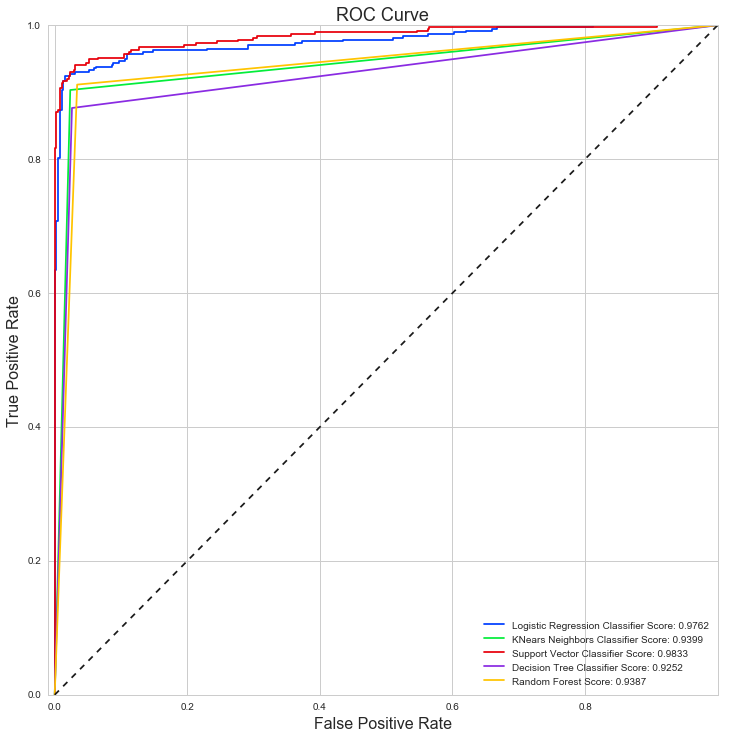

In [83]:
def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr, rdf_fpr, rdf_tpr):
    plt.figure(figsize=(12,12))
    plt.title('ROC Curve', fontsize=18)
    plt.plot(log_fpr, log_tpr,
             label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr,
             label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr,
             label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr,
             label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot(rdf_fpr, rdf_tpr,
             label='Random Forest Score: {:.4f}'.format(roc_auc_score(y_train, rdf_pred)))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

    plt.legend(loc='best')
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr,rdf_fpr, rdf_tpr)
plt.show()

In [86]:
# Neural Network
n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [87]:
undersample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [88]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [89]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 604 samples, validate on 152 samples
Epoch 1/20
 - 0s - loss: 0.9752 - acc: 0.5149 - val_loss: 0.4779 - val_acc: 0.7171
Epoch 2/20
 - 0s - loss: 0.3953 - acc: 0.8228 - val_loss: 0.3650 - val_acc: 0.8092
Epoch 3/20
 - 0s - loss: 0.3002 - acc: 0.9222 - val_loss: 0.3092 - val_acc: 0.8882
Epoch 4/20
 - 0s - loss: 0.2445 - acc: 0.9354 - val_loss: 0.2720 - val_acc: 0.9013
Epoch 5/20
 - 0s - loss: 0.2020 - acc: 0.9421 - val_loss: 0.2437 - val_acc: 0.9079
Epoch 6/20
 - 0s - loss: 0.1715 - acc: 0.9437 - val_loss: 0.2247 - val_acc: 0.9211
Epoch 7/20
 - 0s - loss: 0.1494 - acc: 0.9503 - val_loss: 0.2054 - val_acc: 0.9276
Epoch 8/20
 - 0s - loss: 0.1330 - acc: 0.9536 - val_loss: 0.1989 - val_acc: 0.9276
Epoch 9/20
 - 0s - loss: 0.1210 - acc: 0.9570 - val_loss: 0.1887 - val_acc: 0.9342
Epoch 10/20
 - 0s - loss: 0.1121 - acc: 0.9603 - val_loss: 0.1804 - val_acc: 0.9342
Epoch 11/20
 - 0s - loss: 0.1042 - acc: 0.9603 - val_loss: 0.1774 - val_acc: 0.9276
Epoch 12/20
 - 0s - loss: 0.0966 - acc: